In [1]:
!cd drive/MyDrive

In [2]:
!pip install pandas-profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.3/357.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 29.9 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=58836bd7af02e0d88ec3796bfae8d7be6c0771a8505e54da887d9c9586e667a6
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


In [2]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pandas_profiling import ProfileReport
from sklearn.ensemble import IsolationForest
import optuna
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

In [5]:
start_time = time.time()
data = pd.read_csv('/content/drive/MyDrive/Copy_of_FraudDetectionDataset.csv')
end_time = time.time()

In [6]:
# Randomly Sampling a subset for experimentaion and resource management

random_seed = 42
df_sampled = data.sample(n=600000, random_state=random_seed)

In [7]:
# save the random sample to .csv
df_sampled.to_csv('sampled_dfa23_data.csv',index=False)

#### Data Exploration and Feature Engineering

In [8]:
df_sampled.shape

(600000, 32)

In [9]:
df_sampled.isnull().sum()

Transaction ID                       0
User ID                              0
Transaction Amount                   0
Transaction Date and Time            0
Merchant ID                          0
Payment Method                       0
Country Code                         0
Transaction Type                     0
Device Type                          0
IP Address                           0
Browser Type                         0
Operating System                     0
Merchant Category                    0
User Age                             0
User Occupation                      0
User Income                          0
User Gender                          0
User Account Status                  0
Transaction Status                   0
Location Distance                    0
Time Taken for Transaction           0
Transaction Time of Day              0
User's Transaction History           0
Merchant's Reputation Score          0
User's Device Location               0
Transaction Currency     

In [11]:
df_sampled['Fraudulent Flag'].value_counts(normalize=True)

0    0.50062
1    0.49938
Name: Fraudulent Flag, dtype: float64

In [12]:
# From above it can be seen the distribution of the classes is maintained

In [15]:
# Splitting into train and test data and ensuring stratification around the class 'Fraudulent Flag'
train , test = train_test_split(df_sampled, test_size = 0.3, stratify=df_sampled['Fraudulent Flag'])

In [17]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [10]:
# no null values , now utilizng pandas profiling for a quick EDA of the variable, seeing as the data has been
# sampled down to 600k, we can include correlation and binning , hence 'minimal=False'

### Using Pandas Profiling for EDA around the dataset

In [18]:
profile = ProfileReport(train, minimal=False)

In [20]:
profile.to_file("avonmaet_EDA_report.html")
#profile.to_widgets()

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

The report is attached to this repo

In [21]:
train_ids = train[['Transaction ID','User ID']]
test_ids = test[['Transaction ID','User ID']]

In [22]:
train.columns

Index(['Transaction ID', 'User ID', 'Transaction Amount',
       'Transaction Date and Time', 'Merchant ID', 'Payment Method',
       'Country Code', 'Transaction Type', 'Device Type', 'IP Address',
       'Browser Type', 'Operating System', 'Merchant Category', 'User Age',
       'User Occupation', 'User Income', 'User Gender', 'User Account Status',
       'Transaction Status', 'Location Distance', 'Time Taken for Transaction',
       'Transaction Time of Day', 'User's Transaction History',
       'Merchant's Reputation Score', 'User's Device Location',
       'Transaction Currency', 'Transaction Purpose', 'User's Credit Score',
       'User's Email Domain', 'Merchant's Business Age',
       'Transaction Authentication Method', 'Fraudulent Flag'],
      dtype='object')

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420000 entries, 0 to 419999
Data columns (total 32 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Transaction ID                     420000 non-null  int64  
 1   User ID                            420000 non-null  int64  
 2   Transaction Amount                 420000 non-null  float64
 3   Transaction Date and Time          420000 non-null  object 
 4   Merchant ID                        420000 non-null  int64  
 5   Payment Method                     420000 non-null  object 
 6   Country Code                       420000 non-null  object 
 7   Transaction Type                   420000 non-null  object 
 8   Device Type                        420000 non-null  object 
 9   IP Address                         420000 non-null  object 
 10  Browser Type                       420000 non-null  object 
 11  Operating System                   4200

In [24]:
train_numeric_columns = train.select_dtypes(include=['number'])

In [27]:
train_numeric_columns.drop(['Transaction ID','User ID','Merchant ID','Fraudulent Flag'],axis=1,inplace=True)

### Building a baseline model with Anomaly detection algorithm 'Isolation Forest'

In [29]:
scaler = StandardScaler()
scaler.fit(train_numeric_columns)

StandardScaler()

In [30]:
scaled_train = scaler.transform(train_numeric_columns)

In [32]:
isolation_forest = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination=0.5,
    random_state=42
)

In [33]:
isolation_forest.fit(scaled_train)

IsolationForest(contamination=0.5, random_state=42)

In [34]:
test_numeric_columns = test.select_dtypes(include=['number'])
test_numeric_columns.drop(['Transaction ID','User ID','Merchant ID','Fraudulent Flag'],axis=1,inplace=True)

In [42]:
y_test = test['Fraudulent Flag']

In [35]:
scaled_test = scaler.transform(test_numeric_columns)

In [36]:
y_pred = isolation_forest.predict(scaled_test)

In [37]:
y_pred

array([-1, -1,  1, ...,  1, -1,  1])

In [38]:
y_pred_conv = [0 if i == 1 else 1 for i in y_pred]

In [43]:
print(classification_report(y_test, y_pred_conv))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50     90112
           1       0.50      0.50      0.50     89888

    accuracy                           0.50    180000
   macro avg       0.50      0.50      0.50    180000
weighted avg       0.50      0.50      0.50    180000



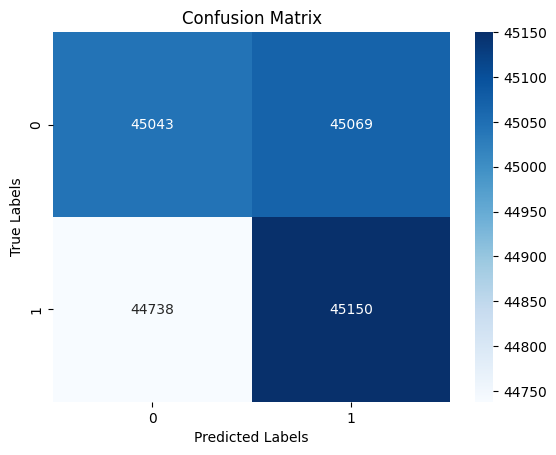

In [49]:
cm = confusion_matrix(y_test, y_pred_conv)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## working with the sampled data:

In [4]:

df = pd.read_csv("/content/drive/MyDrive/sampled_dfa23_data.csv")

In [5]:
# splitting into train & test set in other to avoid any form of data leakage
train , test = train_test_split(df, test_size = 0.3, stratify=df['Fraudulent Flag'])

In [7]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)


In [35]:
train.head()

,Transaction ID,User ID,Transaction Amount,Transaction Date and Time,Merchant ID,Payment Method,Country Code,Transaction Type,Device Type,IP Address,Browser Type,Operating System,Merchant Category,User Age,User Occupation,User Income,User Gender,User Account Status,Transaction Status,Location Distance,Time Taken for Transaction,Transaction Time of Day,User's Transaction History,Merchant's Reputation Score,User's Device Location,Transaction Currency,Transaction Purpose,User's Credit Score,User's Email Domain,Merchant's Business Age,Transaction Authentication Method,Fraudulent Flag
0,40100761,3216,759.18,2022-01-26 01:45:35,1973,Venmo,ITA,Service Charge,E-Reader,177.68.61.170,Silk,macOS,Real Estate,29,Teacher,62961.65,Prefer Not to Say,Verified,Pending Payment,77.44,19.54,Nighttime,75,1.70,Vietnam,KES,Invoice Payment,839,yandex.com,5,Transaction Confirmation Number,1
1,97854047,5888,794.17,2021-05-08 22:40:37,8337,Prepaid Card,POL,Invoice,Smart Appliance,145.88.15.139,Pale Moon,tvOS,Industrial & Scientific,43,Doctor,61826.86,Other,Guest,Held for Security,17.67,44.41,Evening,31,1.75,Canada,AED,Settlement,440,tutanota.com,5,Voice Recognition,1
2,63524171,2880,435.22,2021-05-22 04:50:41,4499,Bitcoin,ESP,Registration Fee,Cash Register,64.2.229.126,Vivaldi,Sailfish OS,Gifts & Souvenirs,55,Electrician,3020.04,Male,Inactive,Partially Approved,93.48,29.14,Evening,21,2.69,Switzerland,SAR,Invoice Payment,588,icloud.com,15,Hardware Token,1
3,31920731,5614,817.76,2021-09-25 11:37:43,8082,Venmo,BEL,Auction,IoT Device,233.29.172.225,ELinks,Linux,Luxury Brands,47,Electrician,32460.10,Non-Binary,VIP,Completed,92.88,12.16,Evening,89,3.83,Argentina,ARS,Settlement,612,yahoo.co.uk,3,Biometric Card,0
4,15886445,8508,599.63,2023-06-14 05:43:04,1934,Stripe,FRA,Recharge,Smart Thermostat,36.13.185.173,Surfraw,FreeBSD,Vintage & Antique,72,Plumber,8755.02,Agender,Closed,Posted,3.95,26.33,Nighttime,32,4.38,Switzerland,TRY,Tax Payment,697,outlook.co.uk,1,Mobile Phone Verification,0


### Feature Engineering & Data Exploration:

In [8]:
train['Transaction Date and Time'] = pd.to_datetime(train['Transaction Date and Time'])
test['Transaction Date and Time'] = pd.to_datetime(test['Transaction Date and Time'])


In [9]:
train['day_of_week'] = train['Transaction Date and Time'].dt.strftime('%w')
test['day_of_week'] = test['Transaction Date and Time'].dt.strftime('%w')


In [37]:
train.head()

,Transaction ID,User ID,Transaction Amount,Transaction Date and Time,Merchant ID,Payment Method,Country Code,Transaction Type,Device Type,IP Address,Browser Type,Operating System,Merchant Category,User Age,User Occupation,User Income,User Gender,User Account Status,Transaction Status,Location Distance,Time Taken for Transaction,Transaction Time of Day,User's Transaction History,Merchant's Reputation Score,User's Device Location,Transaction Currency,Transaction Purpose,User's Credit Score,User's Email Domain,Merchant's Business Age,Transaction Authentication Method,Fraudulent Flag,day_of_week
0,40100761,3216,759.18,2022-01-26 01:45:35,1973,Venmo,ITA,Service Charge,E-Reader,177.68.61.170,Silk,macOS,Real Estate,29,Teacher,62961.65,Prefer Not to Say,Verified,Pending Payment,77.44,19.54,Nighttime,75,1.70,Vietnam,KES,Invoice Payment,839,yandex.com,5,Transaction Confirmation Number,1,3
1,97854047,5888,794.17,2021-05-08 22:40:37,8337,Prepaid Card,POL,Invoice,Smart Appliance,145.88.15.139,Pale Moon,tvOS,Industrial & Scientific,43,Doctor,61826.86,Other,Guest,Held for Security,17.67,44.41,Evening,31,1.75,Canada,AED,Settlement,440,tutanota.com,5,Voice Recognition,1,6
2,63524171,2880,435.22,2021-05-22 04:50:41,4499,Bitcoin,ESP,Registration Fee,Cash Register,64.2.229.126,Vivaldi,Sailfish OS,Gifts & Souvenirs,55,Electrician,3020.04,Male,Inactive,Partially Approved,93.48,29.14,Evening,21,2.69,Switzerland,SAR,Invoice Payment,588,icloud.com,15,Hardware Token,1,6
3,31920731,5614,817.76,2021-09-25 11:37:43,8082,Venmo,BEL,Auction,IoT Device,233.29.172.225,ELinks,Linux,Luxury Brands,47,Electrician,32460.10,Non-Binary,VIP,Completed,92.88,12.16,Evening,89,3.83,Argentina,ARS,Settlement,612,yahoo.co.uk,3,Biometric Card,0,6
4,15886445,8508,599.63,2023-06-14 05:43:04,1934,Stripe,FRA,Recharge,Smart Thermostat,36.13.185.173,Surfraw,FreeBSD,Vintage & Antique,72,Plumber,8755.02,Agender,Closed,Posted,3.95,26.33,Nighttime,32,4.38,Switzerland,TRY,Tax Payment,697,outlook.co.uk,1,Mobile Phone Verification,0,3


In [42]:
train.groupby(['Transaction Time of Day','Fraudulent Flag']).size()

Transaction Time of Day  Fraudulent Flag
Daytime                  0                  70233
                         1                  69739
Evening                  0                  69869
                         1                  69871
Nighttime                0                  70158
                         1                  70130
dtype: int64

In [10]:
categorical_cols = train.select_dtypes(include=['object']).columns

In [11]:
categorical_cols

Index(['Payment Method', 'Country Code', 'Transaction Type', 'Device Type',
       'IP Address', 'Browser Type', 'Operating System', 'Merchant Category',
       'User Occupation', 'User Gender', 'User Account Status',
       'Transaction Status', 'Transaction Time of Day',
       'User's Device Location', 'Transaction Currency', 'Transaction Purpose',
       'User's Email Domain', 'Transaction Authentication Method',
       'day_of_week'],
      dtype='object')

In [12]:
for col in categorical_cols:
  print(train.groupby([col, 'Fraudulent Flag']).size())
  print('=============================================')

Payment Method  Fraudulent Flag
2Checkout       0                  5304
                1                  5118
ACH Transfer    0                  5209
                1                  5274
Afterpay        0                  5225
                                   ... 
Western Union   1                  5188
Wire Transfer   0                  5248
                1                  5216
Worldpay        0                  5180
                1                  5234
Length: 80, dtype: int64
Country Code  Fraudulent Flag
ARG           0                  5298
              1                  5319
AUS           0                  5271
              1                  5254
AUT           0                  5312
                                 ... 
USA           1                  5187
VNM           0                  5289
              1                  5244
ZAF           0                  5258
              1                  5234
Length: 80, dtype: int64
Transaction Type  Fraudulent F

From above, the categorical columns are showing high cardinality and even distribution around the class labels, hence only the 'Time of Day' feature and the 'Day of week' feature would be utilized during the model - 1.0.1 phase.

In [13]:
train['day_of_week'] = train['day_of_week'].astype('int64')
test['day_of_week'] = test['day_of_week'].astype('int64')

In [52]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420000 entries, 0 to 419999
Data columns (total 33 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   Transaction ID                     420000 non-null  int64         
 1   User ID                            420000 non-null  int64         
 2   Transaction Amount                 420000 non-null  float64       
 3   Transaction Date and Time          420000 non-null  datetime64[ns]
 4   Merchant ID                        420000 non-null  int64         
 5   Payment Method                     420000 non-null  object        
 6   Country Code                       420000 non-null  object        
 7   Transaction Type                   420000 non-null  object        
 8   Device Type                        420000 non-null  object        
 9   IP Address                         420000 non-null  object        
 10  Browser Type        

In [14]:
numeric_cols = train.select_dtypes(exclude=['object']).columns.values.tolist()
numeric_cols.append('Transaction Time of Day')

In [15]:
numeric_cols

['Transaction ID',
 'User ID',
 'Transaction Amount',
 'Transaction Date and Time',
 'Merchant ID',
 'User Age',
 'User Income',
 'Location Distance',
 'Time Taken for Transaction',
 "User's Transaction History",
 "Merchant's Reputation Score",
 "User's Credit Score",
 "Merchant's Business Age",
 'Fraudulent Flag',
 'day_of_week',
 'Transaction Time of Day']

In [16]:
df_train = train[numeric_cols]
df_test = test[numeric_cols]

In [17]:
df_train = pd.get_dummies(df_train)
y_train = df_train['Fraudulent Flag']
x_train = df_train.drop(['Transaction Date and Time', 'Fraudulent Flag'], axis=1)

df_test = pd.get_dummies(df_test)
y_test = df_test['Fraudulent Flag']
x_test = df_test.drop(['Transaction Date and Time','Fraudulent Flag'], axis=1)

### Training a XGBoost Model with customly defined metric to optimize for RECALL specifically

In [18]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import recall_score

def custom_recall_metric(preds, dtrain):
    labels = dtrain.get_label()  # Get the true labels from the DMatrix
    predicted_labels = (preds > 0.5).astype(int)  # Convert predicted probabilities to binary labels
    recall = recall_score(labels, predicted_labels)
    return 'custom_recall', recall


In [83]:
params = {
    'objective': 'binary:logistic',

}

dtrain = xgb.DMatrix(x_train, label=y_train)
dval = xgb.DMatrix(x_test, label=y_test)  # Validation dataset

evals = [(dtrain, 'train'), (dval, 'validation')]

model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=evals,
    feval=custom_recall_metric,  #
    early_stopping_rounds=10
)


[0]	train-logloss:0.69291	train-custom_recall:0.00000	validation-logloss:0.69317	validation-custom_recall:0.00000
[1]	train-logloss:0.69261	train-custom_recall:0.00002	validation-logloss:0.69323	validation-custom_recall:0.00001
[2]	train-logloss:0.69244	train-custom_recall:0.00009	validation-logloss:0.69326	validation-custom_recall:0.00002
[3]	train-logloss:0.69225	train-custom_recall:0.00014	validation-logloss:0.69331	validation-custom_recall:0.00006
[4]	train-logloss:0.69209	train-custom_recall:0.00020	validation-logloss:0.69334	validation-custom_recall:0.00009
[5]	train-logloss:0.69190	train-custom_recall:0.00023	validation-logloss:0.69337	validation-custom_recall:0.00009
[6]	train-logloss:0.69162	train-custom_recall:0.00026	validation-logloss:0.69344	validation-custom_recall:0.00010
[7]	train-logloss:0.69139	train-custom_recall:0.00032	validation-logloss:0.69351	validation-custom_recall:0.00012
[8]	train-logloss:0.69122	train-custom_recall:0.00073	validation-logloss:0.69354	validat

In [84]:
dval = xgb.DMatrix(x_test)
y_pred_proba = model.predict(dval)
y_pred = (y_pred_proba > 0.5).astype(int)
classification_report_result = classification_report(y_test, y_pred)


In [85]:
print(classification_report_result)

              precision    recall  f1-score   support

           0       0.50      0.54      0.52     90112
           1       0.50      0.46      0.48     89888

    accuracy                           0.50    180000
   macro avg       0.50      0.50      0.50    180000
weighted avg       0.50      0.50      0.50    180000



## Carrying out Hyper parameter Optimization using Optuna and a custom 'recall' function

In [19]:
from sklearn.metrics import make_scorer, recall_score

def custom_recall(y_true, y_pred):
    return recall_score(y_true, y_pred)


In [20]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }

    # Fit the model
    optuna_model = XGBClassifier(**params)

    # Use make_scorer to create a callable version of the custom recall metric
    custom_recall_scorer = make_scorer(custom_recall, greater_is_better=True)

    return np.mean(cross_val_score(optuna_model, x_train, y_train, cv=skf, scoring=custom_recall_scorer))


In [21]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state = 752)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20,show_progress_bar=True)

[I 2023-09-17 18:38:51,022] A new study created in memory with name: no-name-8dc87d55-0f3e-44e8-b956-987a94779739


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-09-17 18:47:19,466] Trial 0 finished with value: 0.5000095356155239 and parameters: {'max_depth': 4, 'learning_rate': 0.49000449850693867, 'n_estimators': 248, 'min_child_weight': 4, 'gamma': 0.267871268151655, 'subsample': 0.29420543208358096, 'colsample_bytree': 0.32777946588504464, 'reg_alpha': 2.342922707414756e-07, 'reg_lambda': 1.2204961167745404e-06}. Best is trial 0 with value: 0.5000095356155239.
[I 2023-09-17 19:01:23,636] Trial 1 finished with value: 0.4677314770668447 and parameters: {'max_depth': 4, 'learning_rate': 0.01048672556449345, 'n_estimators': 467, 'min_child_weight': 10, 'gamma': 0.27433808154381667, 'subsample': 0.08091656294420506, 'colsample_bytree': 0.40316061533314435, 'reg_alpha': 0.348508109961586, 'reg_lambda': 0.0012176036119708842}. Best is trial 0 with value: 0.5000095356155239.
[I 2023-09-17 19:14:38,792] Trial 2 finished with value: 0.4938972060646515 and parameters: {'max_depth': 8, 'learning_rate': 0.01900373145735103, 'n_estimators': 247, 

# Conclusion :
From the optimization carried out above, the best value is still seen to be hovering around 0.50 for the recall metric, indicative of a close agreement with the earlier generated model performance.

This could be due to the oversampling technique employed to handle the class imbalance in the original dataset, as it may have led to a loss of information while oversampling the minority class by duplicating samples.

# Recommendations :
* Utilizing a different sampling technique, such as SMOTE or ADASYN.
* Present the dataset as the original imbalanced dataset , and techniques to handle the anomalies or imbalance can be carried out by the scientist.